In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
#from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import os.path
import glob
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, normalize
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

/scratch/986487/ipykernel_825610/2025702028.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
!pip3 install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [40]:
!pip3 install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import imblearn

In [3]:
from imblearn.under_sampling import RandomUnderSampler

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
filepath = "combined_data.csv"
df = pd.read_csv(filepath, index_col=None, header=0, low_memory=False)

In [6]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_SEQ_ID,...,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2008,4,11,1,6,19805,AA,1405701,34057,1129802,...,900.0,-5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2008,4,11,1,6,19805,AA,1405701,34057,1393001,...,743.0,-2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2008,4,11,1,6,19805,AA,1129802,30194,1405701,...,1725.0,10.0,10.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2008,4,11,1,6,19805,AA,1405701,34057,1129802,...,625.0,-5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2008,4,11,1,6,19805,AA,1129802,30194,1405701,...,1216.0,-4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [7]:
df.shape

(259987908, 23)

In [8]:
df.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID',
       'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'CANCELLED', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

# Remove features

In [9]:
features_to_remove = ['DEP_DELAY_NEW', 'OP_CARRIER','DEST','DEP_DELAY']

df.drop(columns=features_to_remove, inplace=True)

# Filter out rows with null target values

In [10]:
df = df[df['DEP_DEL15'].notna()]

# Handle Delay Types

In [11]:
delay_types = [
    'CARRIER_DELAY', 
    'WEATHER_DELAY', 
    'NAS_DELAY', 
    'SECURITY_DELAY', 
    'LATE_AIRCRAFT_DELAY'
]

In [12]:
# Fill null values with 0

df[delay_types] = df[delay_types].fillna(0)

In [13]:
# Make non-zero values 1

for col in delay_types:
    df.loc[df[col] > 0, col] = 1

# Remove other null values

In [14]:
df.columns[df.isnull().any()].tolist()


['CRS_DEP_TIME']

In [15]:
df = df[df['CRS_DEP_TIME'].notna()]

In [16]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,CANCELLED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2008,4,11,1,6,19805,1405701,34057,1129802,30194,905.0,900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2008,4,11,1,6,19805,1405701,34057,1393001,30977,745.0,743.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2008,4,11,1,6,19805,1129802,30194,1405701,34057,1715.0,1725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2008,4,11,1,6,19805,1405701,34057,1129802,30194,630.0,625.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2008,4,11,1,6,19805,1129802,30194,1405701,34057,1220.0,1216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Remove duplicates

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df.shape

(136808524, 19)

# Define X and y

In [19]:
X = df.drop(columns=['DEP_DEL15'])
y = df['DEP_DEL15']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# Ordinal Encode

In [21]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
oe.fit(X_train)
X_train_enc = oe.transform(X_train)
X_test_enc = oe.transform(X_test)

print("X_test_enc Prior", X_test_enc.shape)
nan_ind = np.isnan(X_test_enc).any(axis=1)
X_test_enc = X_test_enc[~nan_ind]
print("X_test_enc After", X_test_enc.shape)

X_test_enc Prior (41042558, 18)
X_test_enc After (41042541, 18)


In [22]:
X_train = pd.DataFrame(X_train_enc, columns = X_train.columns)
X_test = pd.DataFrame(X_test_enc, columns = X_test.columns)

# Label Encode

In [23]:
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)[~nan_ind]

In [24]:
y_train = pd.Series(y_train_enc, name = y_train.name)
y_test = pd.Series(y_test_enc, name = y_test.name)

In [25]:
X_test.to_csv('preprocessed/X_test.csv', index=False) 
print("Saved X_test")
y_test.to_csv('preprocessed/y_test.csv', index=False)  
print("Saved y_test")

Saved X_test
Saved y_test


# Downsampling

In [26]:
rd = RandomUnderSampler(random_state=42)

In [27]:
X_train_res, y_train_res = rd.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))

Resampled dataset shape Counter({0: 17538713, 1: 17538713})


In [28]:
X_train_res.to_csv('./preprocessed/X_train_res.csv', index=False) 
print("Saved X_train_res")
y_train_res.to_csv('./preprocessed/y_train_res.csv', index=False)  
print("Saved y_train_res")

Saved X_train_res
Saved y_train_res


In [6]:
X_train_res = pd.read_csv("preprocessed/X_train_res.csv", index_col=None, header=0, low_memory=False)

In [7]:
y_train_res = pd.read_csv("preprocessed/y_train_res.csv", index_col=None, header=0, low_memory=False)

In [10]:
y_test = pd.read_csv("preprocessed/y_test.csv", index_col=None, header=0, low_memory=False)

In [18]:
X_test = pd.read_csv("preprocessed/X_test.csv", index_col=None, header=0, low_memory=False)

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [8]:
from tqdm import tqdm

In [12]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 16, warm_start = True)

# Train the model using the training data
for i in tqdm(range(1, rf_model.n_estimators + 1)):
    rf_model.set_params(n_estimators=i)
    rf_model.fit(X_train_res, y_train_res)

  0%|          | 0/100 [00:00<?, ?it/s]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
  1%|          | 1/100 [01:25<2:21:26, 85.72s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
  2%|▏         | 2/100 [02:49<2:17:57, 84.46s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
  3%|▎         | 3/100 [04:13<2:16:32, 84.46s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A c

 28%|██▊       | 28/100 [39:23<1:40:31, 83.76s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 29%|██▉       | 29/100 [40:46<1:39:09, 83.80s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 30%|███       | 30/100 [42:10<1:37:49, 83.85s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 31%|███       | 31/100 [43:30<1:34:53, 82.51s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversi

 56%|█████▌    | 56/100 [1:18:24<1:01:53, 84.39s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 57%|█████▋    | 57/100 [1:19:49<1:00:45, 84.79s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 58%|█████▊    | 58/100 [1:21:13<59:10, 84.53s/it]  /scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 59%|█████▉    | 59/100 [1:22:38<57:47, 84.57s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataCo

 86%|████████▌ | 86/100 [2:00:21<19:51, 85.12s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 87%|████████▋ | 87/100 [2:01:47<18:29, 85.36s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 88%|████████▊ | 88/100 [2:03:11<16:57, 84.77s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_res, y_train_res)
 89%|████████▉ | 89/100 [2:04:33<15:25, 84.13s/it]/scratch/964678/ipykernel_3848697/194529326.py:7: DataConversi

In [14]:
import joblib

In [14]:
joblib.dump(rf_model, 'random_forest_model_all.joblib')

['random_forest_model_all.joblib']

In [15]:
loaded_rf_model = joblib.load('random_forest_model_all.joblib')

In [6]:
#X_test = pd.read_csv("preprocessed/X_test.csv", index_col=None, header=0, low_memory=False)

In [11]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [12]:
#y_pred = loaded_rf_model.predict(X_test)
#y_pred = rf_model.predict(X_test)
# Initialize an array to store predictions
y_pred = np.empty(len(X_test), dtype=int)

batch_size = 100
for i in tqdm(range(0, len(X_test), batch_size), desc="Predicting"):
    batch = X_test.iloc[i:i + batch_size]
    y_pred[i:i + batch_size] = loaded_rf_model.predict(batch)
    
pd.DataFrame(y_pred, columns=['Predictions']).to_csv('predictions.csv', index=False)

Predicting: 100%|██████████| 410426/410426 [3:08:47<00:00, 36.23it/s]  


# Quantitative Metrics

In [13]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9743883303911423


Accuracy: 0.9743883303911423

In [14]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98  33525955
           1       0.91      0.96      0.93   7516586

    accuracy                           0.97  41042541
   macro avg       0.95      0.97      0.96  41042541
weighted avg       0.98      0.97      0.97  41042541



In [15]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[32775750   750205]
 [  300963  7215623]]


# Visualizations

## Feature Importance

In [5]:
import matplotlib.pyplot as plt

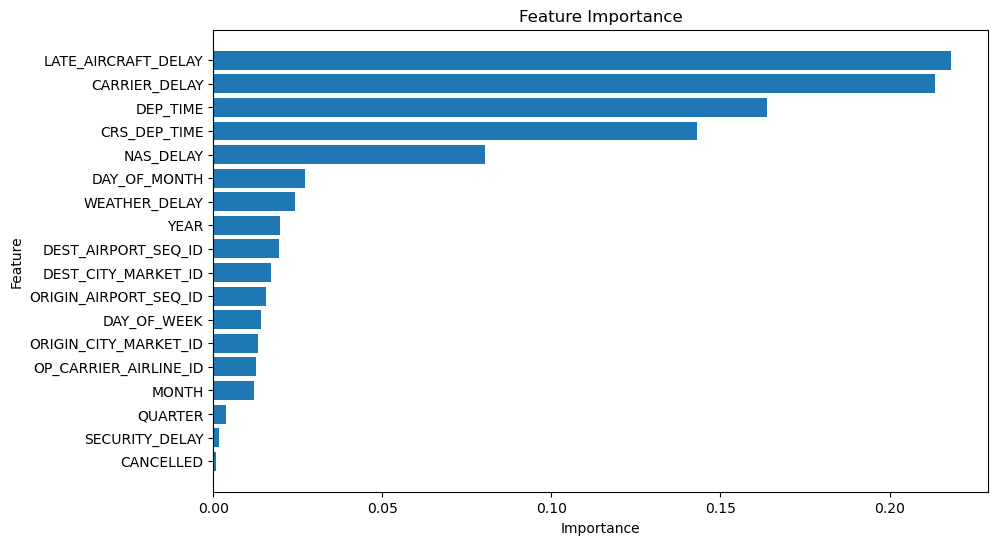

In [17]:
# Get feature importances
feature_importances = loaded_rf_model.feature_importances_

# Create a DataFrame for better visualization (if you have feature names)
features_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Precision-Recall Curve

In [6]:
from sklearn.metrics import PrecisionRecallDisplay

In [7]:
predictions = pd.read_csv('predictions.csv')

In [9]:
y_pred = predictions['Predictions']

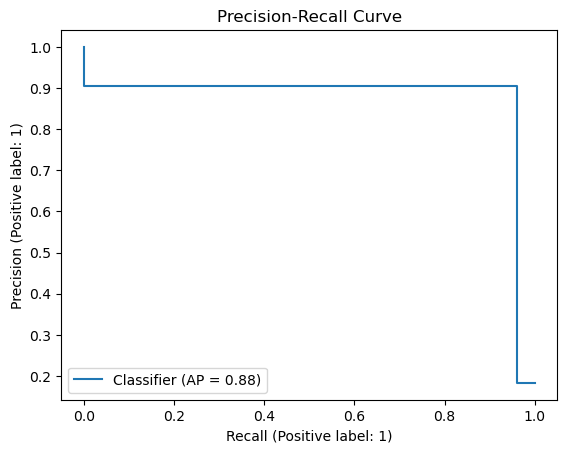

In [11]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.title("Precision-Recall Curve")
plt.show()

## ROC Curve

In [12]:
from sklearn.metrics import RocCurveDisplay

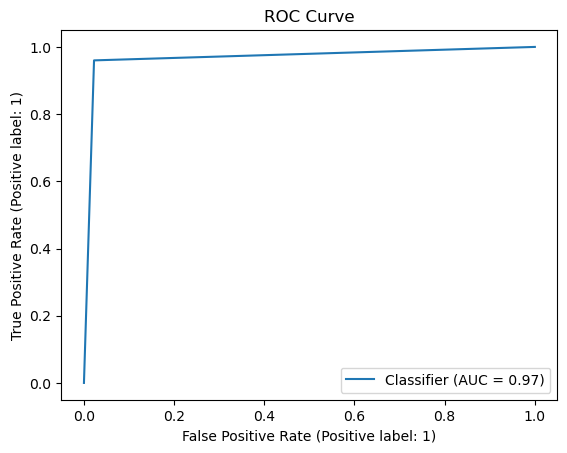

In [13]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("ROC Curve")
plt.show()

## Tree Visualization

In [16]:
from sklearn.tree import plot_tree

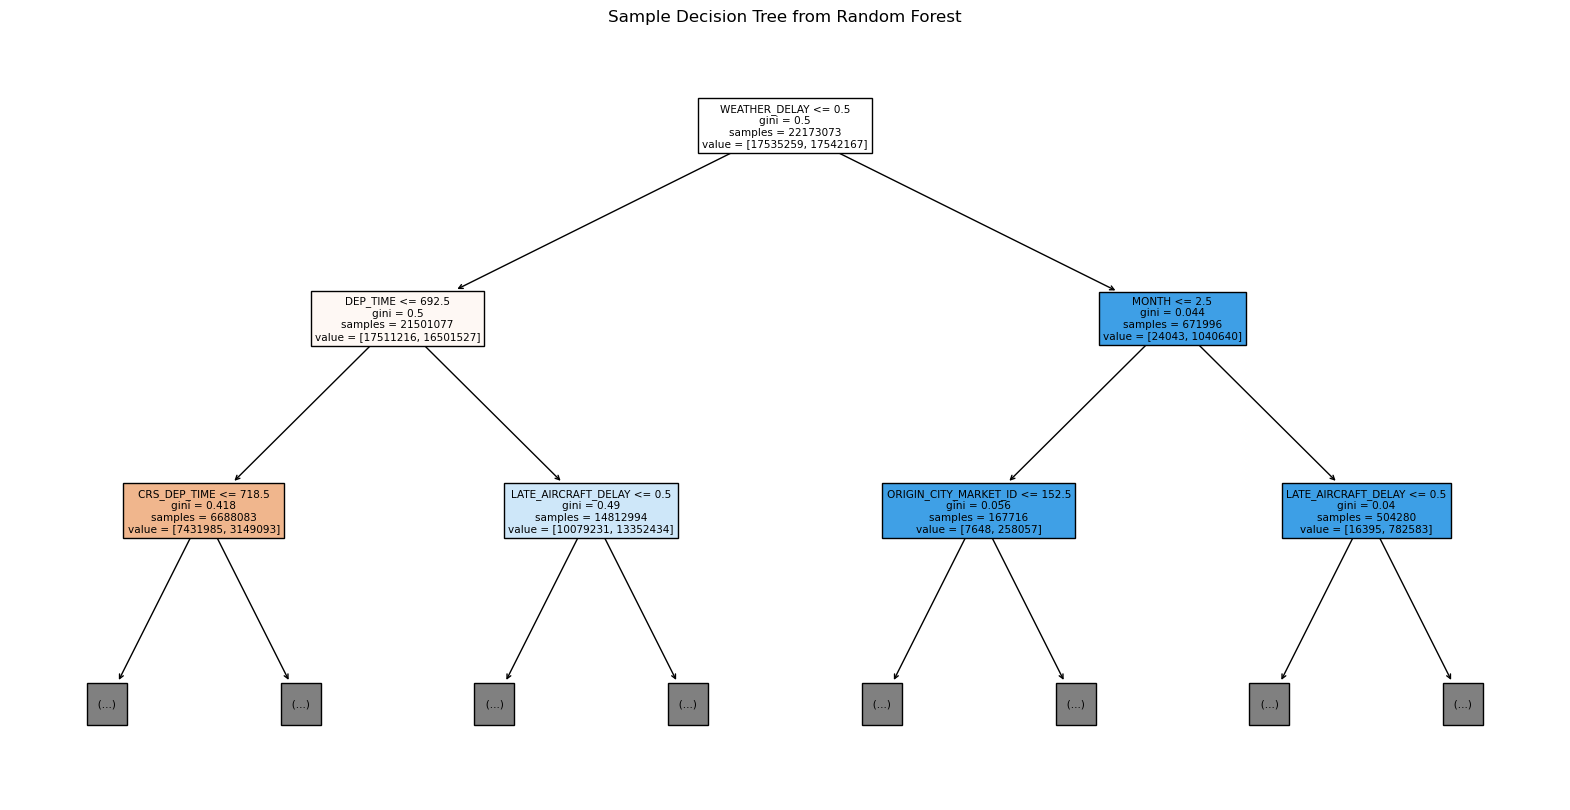

In [19]:
plt.figure(figsize=(20, 10))
plot_tree(loaded_rf_model.estimators_[0], filled=True, max_depth=2, feature_names=X_test.columns)
plt.title("Sample Decision Tree from Random Forest")
plt.show()

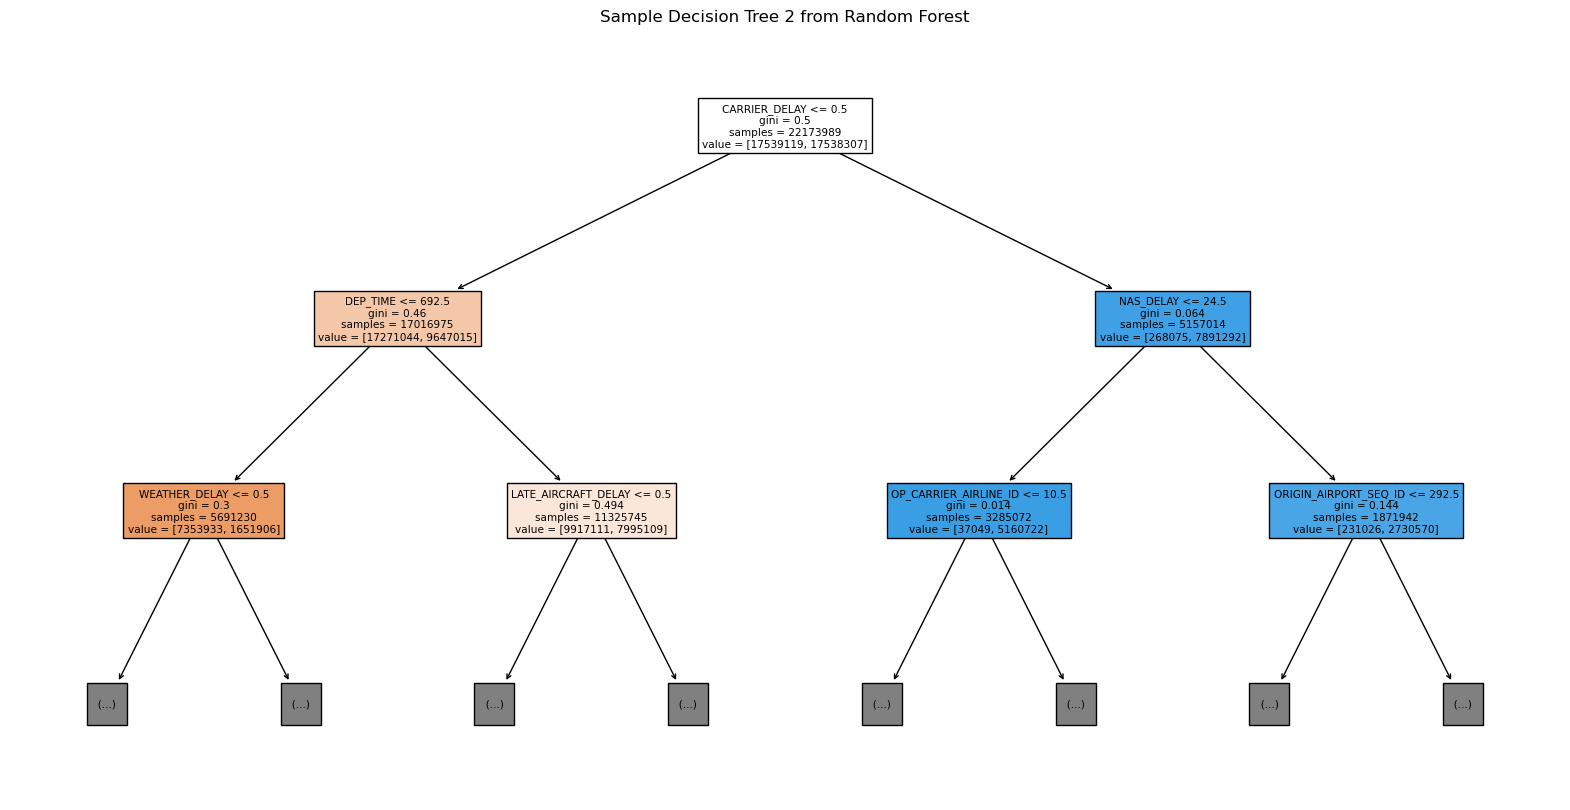

In [20]:
plt.figure(figsize=(20, 10))
plot_tree(loaded_rf_model.estimators_[10], filled=True, max_depth=2, feature_names=X_test.columns)
plt.title("Sample Decision Tree 2 from Random Forest")
plt.show()